# Batch Normalization 

Batch normalization was introduced in Sergey Ioffe's and Christian Szegedy's 2015 paper [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167.pdf). The idea is that, instead of just normalizing the inputs to the network, we normalize the inputs to _layers within_ the network. 
> It's called **batch** normalization because during training, we normalize each layer's inputs by using the mean and variance of the values in the current *batch*.

## Batch Normalization in PyTorch<a id="implementation_1"></a>

This section of the notebook shows you one way to add batch normalization to a neural network built in PyTorch. 

The following cells import the packages we need in the notebook and load the MNIST dataset to use in our experiments.

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                            download=True, transform=transform)

test_data = datasets.MNIST(root='data', train=False,
                           download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers)

### Visualize the data

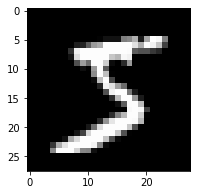

In [4]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

## Neural network classes for testing

The following class, `NeuralNet`, allows us to create identical neural networks **with and without batch normalization** to compare. The code is heavily documented, but there is also some additional discussion later. You do not need to read through it all before going through the rest of the notebook, but the comments within the code blocks may answer some of your questions.

*About the code:*
>We are defining a simple MLP for classification; this design choice was made to support the discussion related to batch normalization and not to get the best classification accuracy.

### (Important) Model Details

There are quite a few comments in the code, so those should answer most of your questions. However, let's take a look at the most important lines.

We add batch normalization to layers inside the `__init__` function. Here are some important points about that code:
1. Layers with batch normalization do **not** include a bias term.
2. We use PyTorch's [BatchNorm1d](https://pytorch.org/docs/stable/nn.html#batchnorm1d) function to handle the math. This is the function you use to operate on linear layer outputs; you'll use [BatchNorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d) for 2D outputs like filtered images from convolutional layers. 
3. We add the batch normalization layer **before** calling the activation function.


In [5]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNet(nn.Module):
    def __init__(self, use_batch_norm, input_size=784, hidden_dim=256, output_size=10):
        """
        Creates a PyTorch net using the given parameters.
        
        :param use_batch_norm: bool
            Pass True to create a network that uses batch normalization; False otherwise
            Note: this network will not use batch normalization on layers that do not have an
            activation function.
        """
        super(NeuralNet, self).__init__() # init super
        
        # Default layer sizes
        self.input_size = input_size # (28*28 images)
        self.hidden_dim = hidden_dim
        self.output_size = output_size # (number of classes)
        # Keep track of whether or not this network uses batch normalization.
        self.use_batch_norm = use_batch_norm
        
        # define hidden linear layers, with optional batch norm on their outputs
        # layers with batch_norm applied have no bias term
        if use_batch_norm:
            self.fc1 = nn.Linear(input_size, hidden_dim*2, bias=False)
            self.batch_norm1 = nn.BatchNorm1d(hidden_dim*2)
        else:
            self.fc1 = nn.Linear(input_size, hidden_dim*2)
            
        # define *second* hidden linear layers, with optional batch norm on their outputs
        if use_batch_norm:
            self.fc2 = nn.Linear(hidden_dim*2, hidden_dim, bias=False)
            self.batch_norm2 = nn.BatchNorm1d(hidden_dim)
        else:
            self.fc2 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # third and final, fully-connected layer
        self.fc3 = nn.Linear(hidden_dim, output_size)
        
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        # all hidden layers + optional batch norm + relu activation
        x = self.fc1(x)
        if self.use_batch_norm:
            x = self.batch_norm1(x)
        x = F.relu(x)
        # second layer
        x = self.fc2(x)
        if self.use_batch_norm:
            x = self.batch_norm2(x)
        x = F.relu(x)
        # third layer, no batch norm or activation
        x = self.fc3(x)
        return x


### Create two different models for testing

* `net_batchnorm` is a linear classification model **with** batch normalization applied to the output of its hidden layers
* `net_no_norm` is a plain MLP, without batch normalization

Besides the normalization layers, everthing about these models is the same.

In [6]:
net_batchnorm = NeuralNet(use_batch_norm=True)
net_no_norm = NeuralNet(use_batch_norm=False)

print(net_batchnorm)
print()
print(net_no_norm)

NeuralNet(
  (fc1): Linear(in_features=784, out_features=512, bias=False)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=False)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

NeuralNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


---
## Training

The below `train` function will take in a model and some number of epochs. We'll use cross entropy loss and stochastic gradient descent for optimization. This function returns the losses, recorded after each epoch, so that we can display and compare the behavior of different models.

#### `.train()` mode
Note that we tell our model whether or not it should be in training mode, `model.train()`. This is an important step because batch normalization has different behavior during training on a batch or testing/evaluating on a larger dataset.

In [7]:
def train(model, n_epochs=10):
    # number of epochs to train the model
    n_epochs = n_epochs
    # track losses
    losses = []
        
    # optimization strategy 
    # specify loss function (categorical cross-entropy)
    criterion = nn.CrossEntropyLoss()

    # specify optimizer (stochastic gradient descent) and learning rate = 0.01
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    # set the model to training mode
    model.train()
    
    for epoch in range(1, n_epochs+1):
        # monitor training loss
        train_loss = 0.0

        ###################
        # train the model #
        ###################
        batch_count = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update average training loss
            train_loss += loss.item() # add up avg batch loss
            batch_count +=1                

        # print training statistics 
        losses.append(train_loss/batch_count)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            train_loss/batch_count))
    
    # return all recorded batch losses
    return losses
        
      

### Comparing Models

In the below cells, we train our two different models and compare their trainining loss over time.

In [8]:
# batchnorm model losses
# this may take some time to train
losses_batchnorm = train(net_batchnorm)

Epoch: 1 	Training Loss: 0.384665
Epoch: 2 	Training Loss: 0.160423
Epoch: 3 	Training Loss: 0.111933
Epoch: 4 	Training Loss: 0.083671
Epoch: 5 	Training Loss: 0.064173
Epoch: 6 	Training Loss: 0.049817
Epoch: 7 	Training Loss: 0.039018
Epoch: 8 	Training Loss: 0.030776
Epoch: 9 	Training Loss: 0.024465
Epoch: 10 	Training Loss: 0.019651


In [9]:
# *no* norm model losses
# you should already start to see a difference in training losses
losses_no_norm = train(net_no_norm)

Epoch: 1 	Training Loss: 1.571514
Epoch: 2 	Training Loss: 0.512825
Epoch: 3 	Training Loss: 0.377129
Epoch: 4 	Training Loss: 0.329442
Epoch: 5 	Training Loss: 0.299627
Epoch: 6 	Training Loss: 0.276747
Epoch: 7 	Training Loss: 0.257520
Epoch: 8 	Training Loss: 0.240777
Epoch: 9 	Training Loss: 0.225909
Epoch: 10 	Training Loss: 0.212584


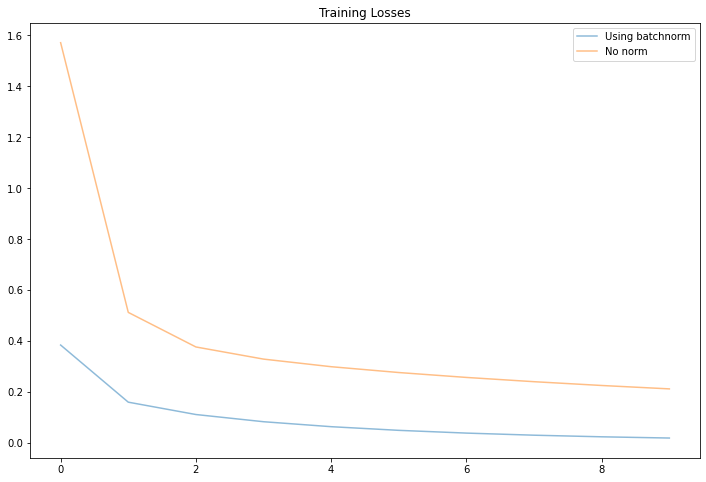

In [10]:
# compare
fig, ax = plt.subplots(figsize=(12,8))
#losses_batchnorm = np.array(losses_batchnorm)
#losses_no_norm = np.array(losses_no_norm)
plt.plot(losses_batchnorm, label='Using batchnorm', alpha=0.5)
plt.plot(losses_no_norm, label='No norm', alpha=0.5)
plt.title("Training Losses")
plt.legend()

---
## Testing

You should see that the model with batch normalization, starts off with a lower training loss and, over ten epochs of training, gets to a training loss that is noticeably lower than our model without normalization.

Next, let's see how both these models perform on our test data! Below, we have a function `test` that takes in a model and a parameter `train` (True or False) which indicates whether the model should be in training or evaulation mode. This is for comparison purposes, later. This function will calculate some test statistics including the overall test accuracy of a passed in model.


In [11]:
def test(model, train):
    # initialize vars to monitor test loss and accuracy
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    test_loss = 0.0

    # set model to train or evaluation mode
    # just to see the difference in behavior
    if(train==True):
        model.train()
    if(train==False):
        model.eval()
    
    # loss criterion
    criterion = nn.CrossEntropyLoss()
    
    for batch_idx, (data, target) in enumerate(test_loader):
        batch_size = data.size(0)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss += loss.item()*batch_size
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    print('Test Loss: {:.6f}\n'.format(test_loss/len(test_loader.dataset)))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

### Training and Evaluation Mode

Setting a model to evaluation mode is important for models with batch normalization layers!

>* Training mode means that the batch normalization layers will use **batch** statistics to calculate the batch norm. 
* Evaluation mode, on the other hand, uses the estimated **population** mean and variance from the entire training set, which should give us increased performance on this test data! 

In [12]:
# test batchnorm case, in *train* mode
test(net_batchnorm, train=True)

Test Loss: 0.081084

Test Accuracy of     0: 99% (971/980)
Test Accuracy of     1: 99% (1126/1135)
Test Accuracy of     2: 96% (1000/1032)
Test Accuracy of     3: 97% (984/1010)
Test Accuracy of     4: 97% (961/982)
Test Accuracy of     5: 97% (867/892)
Test Accuracy of     6: 97% (932/958)
Test Accuracy of     7: 97% (998/1028)
Test Accuracy of     8: 97% (949/974)
Test Accuracy of     9: 96% (973/1009)

Test Accuracy (Overall): 97% (9761/10000)


In [13]:
# test batchnorm case, in *evaluation* mode
test(net_batchnorm, train=False)

Test Loss: 0.068900

Test Accuracy of     0: 99% (971/980)
Test Accuracy of     1: 99% (1125/1135)
Test Accuracy of     2: 97% (1010/1032)
Test Accuracy of     3: 98% (995/1010)
Test Accuracy of     4: 97% (953/982)
Test Accuracy of     5: 97% (872/892)
Test Accuracy of     6: 97% (934/958)
Test Accuracy of     7: 96% (995/1028)
Test Accuracy of     8: 97% (946/974)
Test Accuracy of     9: 97% (988/1009)

Test Accuracy (Overall): 97% (9789/10000)


In [14]:
# for posterity, test no norm case in eval mode
test(net_no_norm, train=False)

Test Loss: 0.204132

Test Accuracy of     0: 98% (964/980)
Test Accuracy of     1: 98% (1113/1135)
Test Accuracy of     2: 91% (944/1032)
Test Accuracy of     3: 93% (945/1010)
Test Accuracy of     4: 93% (915/982)
Test Accuracy of     5: 93% (833/892)
Test Accuracy of     6: 95% (914/958)
Test Accuracy of     7: 93% (959/1028)
Test Accuracy of     8: 90% (885/974)
Test Accuracy of     9: 93% (940/1009)

Test Accuracy (Overall): 94% (9412/10000)


### Which model has the highest accuracy?

You should see a small improvement when comparing the batch norm model's accuracy in training and evaluation mode; **evaluation mode** should give a small improvement!

You should also see that the model that uses batch norm layers shows a marked improvement in overall accuracy when compared with the no-normalization model.

---
# Considerations for other network types

This notebook demonstrates batch normalization in a standard neural network with fully connected layers. You can also use batch normalization in other types of networks, but there are some special considerations.

### ConvNets

Convolution layers consist of multiple feature maps. (Remember, the depth of a convolutional layer refers to its number of feature maps.) And the weights for each feature map are shared across all the inputs that feed into the layer. Because of these differences, batch normalizing convolutional layers requires batch/population mean and variance per feature map rather than per node in the layer.

> To apply batch normalization on the outputs of convolutional layers, we use [BatchNorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d)


### RNNs

Batch normalization can work with recurrent neural networks, too, as shown in the 2016 paper [Recurrent Batch Normalization](https://arxiv.org/abs/1603.09025). It's a bit more work to implement, but basically involves calculating the means and variances per time step instead of per layer. You can find an example where someone implemented recurrent batch normalization in PyTorch, in [this GitHub repo](https://github.com/jihunchoi/recurrent-batch-normalization-pytorch).